<a href="https://colab.research.google.com/github/sabrinazhengliu/Applied-Deep-Learning/blob/main/Neural_Network_Block_Modularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## APPM 4720 Applied Deep Learning, Fall 2021
## Progress Report 02 - VGGNet, Resnet, Inception_v3
## Sabrina Liu, September 17, 2021
The objectives of this progress report is as below:
* build a standard workflow to modularize commonly used neural network blocks (e.g. residual block, etc.)
* explore options to visualze neural network structure
* compare the performance of several different neural network architectures

Tutorials:
* How to Develop VGG, Inception and ResNet Modules from Scratch in Keras 
  * https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

#### Import Dependencies

In [85]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.layers import AveragePooling2D
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras import backend as K

#### Create VGG Block
A VGG block is a simple form of CNN block that consists of two to four 3x3 (sometimes 1x1) convolutional filters followed by max pooling. Stacking VGG blocks together allows us to quickly build very deep neural networks that are extensions to the AlexNet. For hyper-parameter search, we care about below configurations when designing a VGG block:
* layers of convolutional filters - 2|3|4
* number of convolutional filters in each layer (width) - 64|128|256|512
* use 1x1 convolution or not - True|False


In [34]:
# create a function for adding a vgg block to the model in Keras
def vgg_block(x, n_filters=64, n_conv=2):

    # add convolutional layers
    for _ in range(n_conv):
        x = Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    # add max pooling layer
    z = MaxPooling2D((2,2), strides=(2,2))(x)
    return z

#### Inspect Block Architecture
For very deep neural networks with predefined blocks, it's both challenging and redundant to visualize the entire network architecture. But it is valuable to inspect the architecture inside the block to understand the operations. 

In [35]:
# create a function inspect the architecture of modularized block with default hyper-parameters
def inspect_block(block_module, input_shape=(224,224,3), **kwargs):
    
    # reset layer name index
    K.clear_session()

    # define model input dimensions
    x = Input(shape=input_shape)
    
    # add block module with default hyper-parameters
    z = block_module(x)
    
    # create model to the scope of the block
    model = Model(inputs=x, outputs=z, name=block_module.__name__)
    
    # inspect block parameters
    display(model.summary())
    
    # inspect block architecture
    out_file = f'{block_module.__name__}_{str(kwargs)}.png'
    display(plot_model(model, show_shapes=True, to_file=out_file))

    return

Model: "vgg_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


None

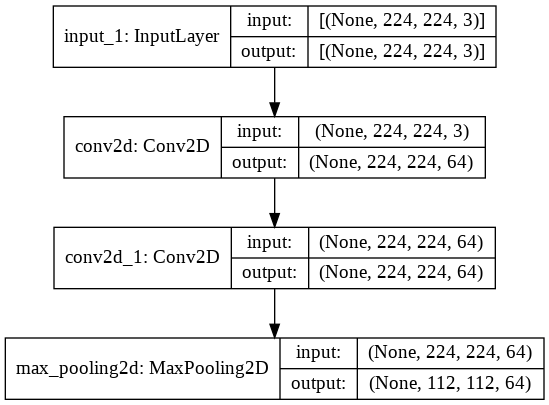

In [36]:
inspect_block(vgg_block, n_filters=64, n_conv=2)

#### Create Residual Blocks

In [93]:
def residual_block(x, n_filters=64, n_conv=2, reduce_first=False):

    id_block = x

	  # check if the number of filters needs to be increase, assumes channels last format
    if x.shape[-1] != n_filters:
        id_block = Conv2D(filters=n_filters, 
                          kernel_size=(1,1), 
                          strides=2 if reduce_first else 1,
                          padding='same', 
                          activation='relu', 
                          kernel_initializer='he_normal')(x)

    for i in range(n_conv):
        x = Conv2D(filters=n_filters, 
                   kernel_size=(3,3), 
                   strides=2 if (i==0) and reduce_first else 1,
                   padding='same',
                   activation='linear' if i == (n_conv - 1) else 'relu', 
                   kernel_initializer='he_normal')(x)

    # add filters, assumes filters/channels last
    layer_out = add([x, id_block])
    
    # activation function
    layer_out = Activation('relu')(layer_out)
    
    return layer_out

Model: "residual_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 256         input_1[0][0]                    
_____________________________________________________________________________________

None

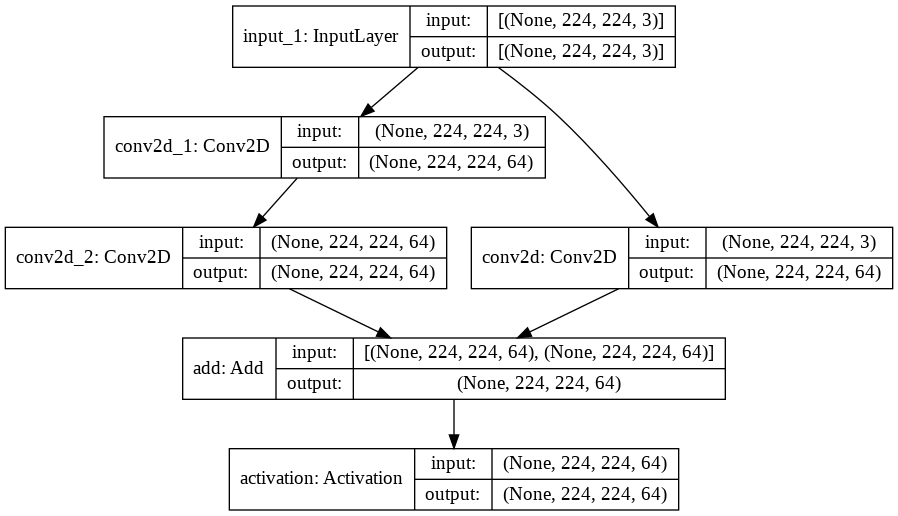

In [94]:
inspect_block(residual_block, n_filters=64, n_conv=2)

#### Adding Blocks to Models

In [103]:
def build_classic_resnet(depth=18, 
                         input_shape = (224, 224, 3), 
                         n_classes = 1000,
                         n_convs=[2,2,2,2]):

    # reset layer name index
    K.clear_session()

    # define model input dimensions
    x = Input(shape=input_shape)

    # add the initial convolutional layer and max pooling layer
    z = Conv2D(filters=64, 
              kernel_size=(7,7), 
              strides=2, 
              padding='same', 
              kernel_initializer='he_normal')(x)
    z = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(z)

    # add block modules according to configuration table
    z = residual_block(z, n_filters=64,  n_conv=n_convs[0])
    z = residual_block(z, n_filters=128, n_conv=n_convs[1], reduce_first=True)
    z = residual_block(z, n_filters=256, n_conv=n_convs[2], reduce_first=True)
    z = residual_block(z, n_filters=512, n_conv=n_convs[3], reduce_first=True)

    # wrap up with average pooling, dense layer and softmax
    z = AveragePooling2D(pool_size=7)(z)
    z = Dense(units=n_classes)(z)
    z = Activation('softmax')(z)

    # create model to the scope of the block
    model = Model(inputs=x, outputs=z, name=f'ResNet-{depth}')
    return model

In [104]:
ResNet18 = build_classic_resnet(depth=18, n_convs=[2,2,2,2])
ResNet18.summary()

Model: "ResNet-18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   36928       max_pooling2d[0][0]              
__________________________________________________________________________________________

In [105]:
ResNet34 = build_classic_resnet(depth=34, n_convs=[3,4,6,3])
ResNet34.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   36928       max_pooling2d[0][0]              
__________________________________________________________________________________________